In [ ]:
import itertools
import random
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import Adam
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [ ]:
class SequentialMNISTDataset(Dataset):
    """
    A custom Dataset for sequential MNIST, where each image (28x28)
    is flattened into a sequence of length 784.
    """

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        seq = img.squeeze(0)
        #seq = img.view(-1)  # Flatten 28x28 -> 784
        return seq, label

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim=28, hidden_dim=128, output_dim=10, num_layers=1):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh')
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Final fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Zero initialization
        nn.init.zeros_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        # Reshape input to (batch_size, seq_len, input_dim)
        #x = x.unsqueeze(-1)

        # RNN layer
        out, _ = self.rnn(x)

        # Use the final time step's output for classification
        out = out[:, -1, :]

        # Fully connected layer
        out = self.fc(out)

        return F.softmax(out, dim=1)

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    running_correct = 0
    total_samples = 0

    for batch_idx, (data, targets) in enumerate(dataloader):
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == targets).sum().item()
        running_correct += correct
        running_loss += loss.item() * data.size(0)
        total_samples += data.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_correct / total_samples
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    train_running_loss = 0
    train_running_acc = 0
    total_samples = 0

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)

            loss = criterion(outputs, targets)
            _, predicted = torch.max(outputs.data, 1)

            train_running_acc += (predicted == targets).sum().item()
            train_running_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

    epoch_loss = train_running_loss / total_samples
    epoch_acc = train_running_acc / total_samples
    return epoch_loss, epoch_acc


def plot_training_curves(loss_log, val_loss_log, acc_log, val_acc_log, train_dataset_size, batch_size):
    fig, ax1 = plt.subplots(figsize=(16, 9))

    color = 'tab:red'
    # Plot train & val loss
    ax1.plot(range(len(loss_log)), loss_log, c=color, alpha=0.25, label="Train Loss")
    # For val loss, plot at points roughly corresponding to the epochs
    ax1.plot(
        [np.ceil((i + 1) * train_dataset_size / batch_size) for i in range(len(val_loss_log))],
        val_loss_log,
        c="red",
        label="Val. Loss"
    )
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Avg. Cross-Entropy Loss", c=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(-0.01, 3)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    # Plot train & val accuracy
    ax2.plot(range(len(acc_log)), acc_log, c=color, label="Train Acc.", alpha=0.25)
    ax2.plot(
        [np.ceil((i + 1) * train_dataset_size / batch_size) for i in range(len(val_acc_log))],
        val_acc_log,
        c="blue",
        label="Val. Acc."
    )
    ax2.set_ylabel("Accuracy", c=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(-0.01, 1.01)

    fig.tight_layout()
    ax1.legend(loc="center")
    ax2.legend(loc="center right")
    plt.show()

Using device: cpu
Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.29MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.46MB/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Batch inputs shape: torch.Size([128, 28, 28])
Batch targets shape: torch.Size([128])
[Epoch 1]   Loss:  2.084693118158976     Train Acc:  38.016666666666666%      Val Acc:  39.96%
[Epoch 2]   Loss:  2.0179610819498697     Train Acc:  44.52333333333333%      Val Acc:  46.96%
[Epoch 3]   Loss:  1.99164265276591     Train Acc:  47.218333333333334%      Val Acc:  44.98%
[Epoch 4]   Loss:  1.9760321011861166     Train Acc:  48.718333333333334%      Val Acc:  52.04%
[Epoch 5]   Loss:  1.928874134381612     Train Acc:  53.525%      Val Acc:  56.940000000000005%
[Epoch 6]   Loss:  1.8735047734578452     Train Acc:  59.21666666666666%      Val Acc:  63.21%
[Epoch 7]   Loss:  1.8900008120218912     Train Acc:  57.38166666666666%      Val Acc:  58.58%
[Epoch 8]   Loss:  1.8279502626419066     Train Acc:  63.58166666666667%      Val Acc:  65.72%
[Epoch 9]   Loss:  1.8266434379577636     Train Acc:  63.739999999999995%      Val Acc:  69.61%
[Epoch 10]   Loss:  1.7280962368647257     Train Acc:  74.

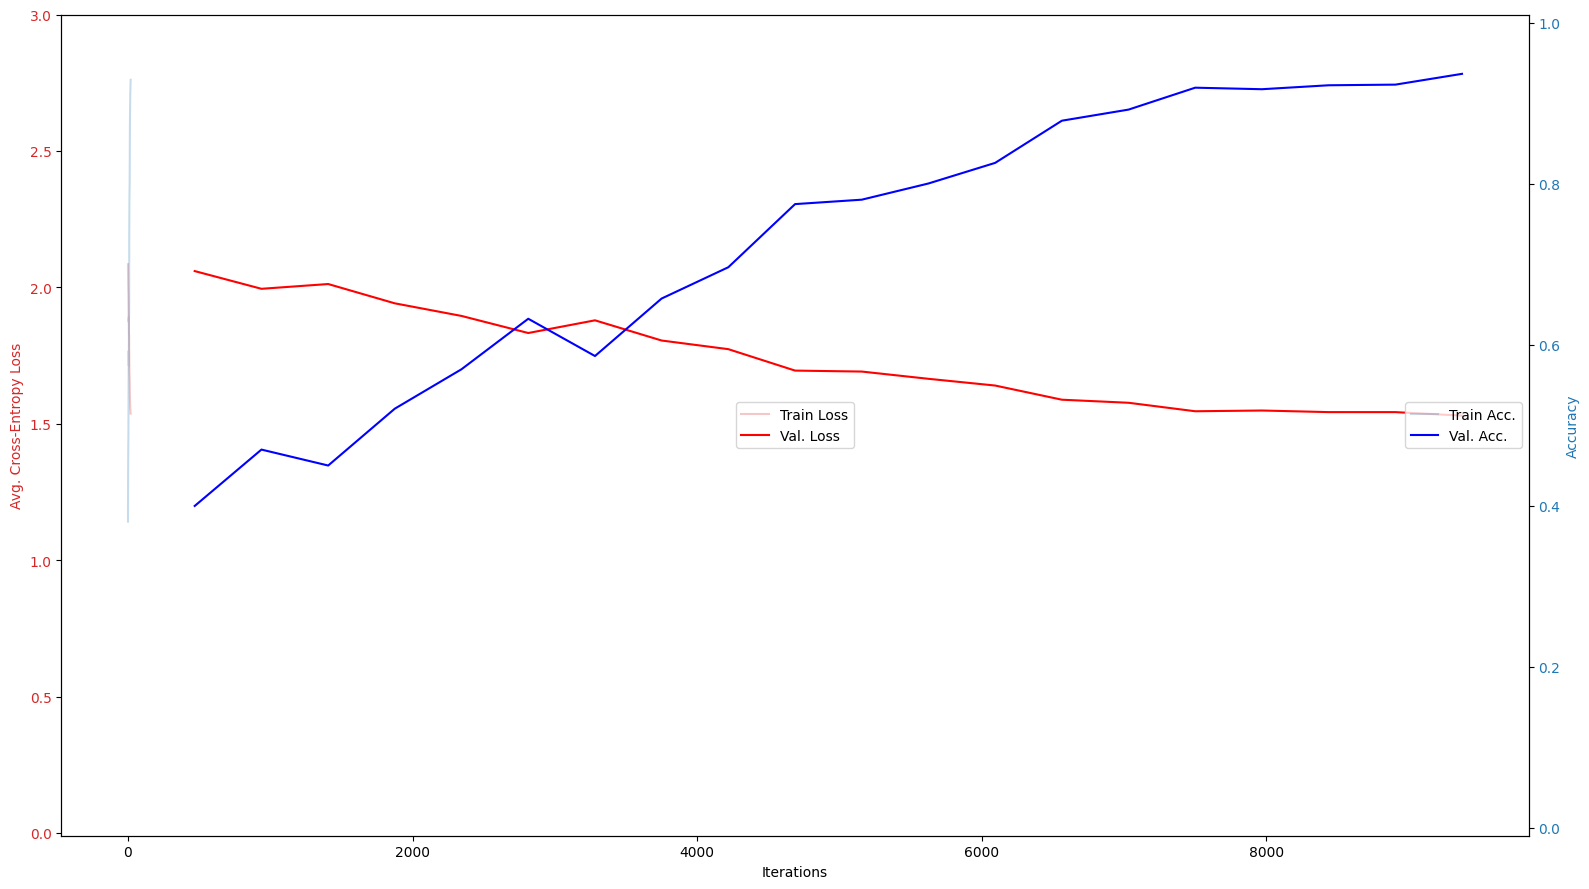

In [ ]:
def main():
    # Hyperparameters
    max_epochs = 20
    batch_size = 128
    lr = 1e-3
    weight_decay = 0.001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load the MNIST dataset
    train_data = datasets.MNIST(
        root='./mnist_data/',
        train=True,
        transform=transforms.ToTensor(),
        download=True
    )
    val_data = datasets.MNIST(
        root='./mnist_data/',
        train=False,
        transform=transforms.ToTensor()
    )

    # Organize the MNIST dataset into SequentialMNISTDataset
    train_seq_data = SequentialMNISTDataset(train_data)
    val_seq_data = SequentialMNISTDataset(val_data)

    # Data loaders
    train_loader = DataLoader(train_seq_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_seq_data, batch_size=batch_size, shuffle=False, num_workers=2)

    # Example of fetching a batch
    example_data, example_targets = next(iter(train_loader))
    print("Batch inputs shape:", example_data.shape)  # (batch_size, 784)
    print("Batch targets shape:", example_targets.shape)  # (batch_size,)

    # Initialize model, optimizer, and loss function
    model = Net().to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    loss_log, val_loss_log = [], []
    acc_log, val_acc_log = [], []
    # Training loop
    for epoch in range(max_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Log per epoch results
        print(f"[Epoch {epoch + 1}]   Loss:  {train_loss}     Train Acc:  {train_acc * 100}%      Val Acc:  {val_acc * 100}%")

        #if len(val_loss_log) != 0 and val_loss_log[-1] > val_loss:
        #    torch.save(model.state_dict(), './model.pt')

        # Save epoch-level logs
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        # For iteration-level logs
        loss_log.append(train_loss)
        acc_log.append(train_acc)

    # Plot training curves
    plot_training_curves(loss_log, val_loss_log, acc_log, val_acc_log, len(train_data), batch_size)


if __name__ == "__main__":
    main()